# Probabilistic Programming: Introduction to PyMC3

##### Disclaimer
Most of the material presented here is taken from the pymc3 tutorials and examples. The notes and figures on MCMC are taken from [Micheal Betancourt's "A conceptual introduction to Hamiltonian Monte Carlo"](https://arxiv.org/pdf/1701.02434.pdf) and [Hoffman and Gelman's "The No-U-Turn Sampler:  Adaptively Setting Path Lengthsin Hamiltonian Monte Carlo"](https://arxiv.org/pdf/1111.4246.pdf).

## Brief background
All the statistical methods that we have seen so far concentrated on probabilistic graphical models (also called [statistical models](https://en.wikipedia.org/wiki/Statistical_model)): random variables (RVs) that conditionally depend on each other through some probability distribution, or mathematical relation. Using Bayes theorem we could then write down algorithms to infer unobserved random variables in the graph. We either inferred the maximum likelihood (ML), maximum a posteriori (MAP), or the full or approximate posterior probability distribution.

The key ingredients we used were:

* Random variables (RVs): these may be conditionally dependent or independent as expressed by the graphical model that is used
* Probability distributions or densities (pdf): each RV's value is assumed to be a random sample from some distribution, which may depend on other RVs.
* The unnormalized likelihood of the graphical model given some observed values on a subset of RVs.

Combining all of these ingredients together with Bayes theorem gives us the unnormalized posterior probability density:

$$
P\left(\vec{x}\mid y\right) \propto P\left(y\mid \vec{x}\right) P\left(\vec{x}\right)
$$

Usually, it's impossible to compute normalization constant:
$$
\int d\vec{x} P\left(y\mid \vec{x}\right)
$$
This means that it is usually impossible to compute the true posterior probability distribution $P\left(\vec{x}\mid y\right)$ analytically. That is why we resort to maximum likelihood, MAP or approximations like Laplace (used with Gaussian Process Classifiers, GPC) or variational inference (used with the Gaussian Mixture Models, GMM).

## Probabilistic Programming Languages (PPL)

PPL aim to __provide the thee key ingredients listed above__ as ready to use building blocks, that can be used to __easily express any form of probabilistic graphical model__. The PPL then exploits the conditional dependence structures of the graphical model, computes the unnormalized likelihoods and exposes ready to use methods for doing point estimates (ML, MAP), approximate posteriors (Variational Inference) or __draw samples from the true posterior probability distribution__ (usually done through Markov Chain Monte Carlo MCMC).

Some notable PPL:
* [PyMC](https://docs.pymc.io/)
* [Stan](https://mc-stan.org/)
* [Edward](https://www.tensorflow.org/probability/api_docs/python/tfp/edward2)
* [Pyro](http://pyro.ai/)

We will focus on [PyMC3](https://github.com/pymc-devs/pymc3) which is the current stable release, which uses [theano](http://deeplearning.net/software/theano/) as the computational backend, but the [next version](https://github.com/pymc-devs/pymc4) will be built on top of [tensorflow2](https://www.tensorflow.org/alpha/guide/effective_tf2).

---

## Short word on MCMC

Typical inference scenario:
1. You observe some data
2. You come up with a model that explains how the data was generated
3. The model depends on unknown parameter values
4. You want to learn the parameters from the observed data in order to make __good predictions__

Learn may mean many things, but in practical situations it is whatever allows you to make good predictions. The simplest approach is to find the most likely set of parameters given the data (ML, MAP).

##### What's wrong with MAP?
It's usually fine for models with few parameters, but as the number of parameters increase, the curse of dimensionality takes hold. With many parameters, the locations in parameter space with high density, may not carry much __probability mass__.

Imagine that our posterior probability distribution were given by an N dimensional normal distribution (mean 0, standard deviation 1). The most likely parameter value (MAP) will be N dimensional zero vector.

However, when `N` is large, the average distance of any sample from the posterior to the origin (the MAP) tends to be 1! This means that the location with the highest density (MAP) is highly unlikely! The parts of the parameter space that have a large probability _mass_ is called the __typical set__.

In [1]:
import numpy as np
Ns = np.logspace(0, 6, 7).astype(np.int)
f = [np.sqrt(np.sum(np.random.randn(100, n)**2, axis=1))/n for n in Ns]

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharey=True)
for ff, n in zip(f, Ns):
    sns.kdeplot(ff, label='{}'.format(n), ax=axs[0])
    sns.kdeplot(ff, label='{}'.format(n), ax=axs[1])
axs[0].set_xlim([0, 5])
axs[0].set_ylim([0, 5])
axs[1].set_xscale('log')
plt.legend()

##### But why does this happen?

We are interested in expectation values of some functions taken on the posterior probability $f(q) \pi(q)$
$$
\mathbb{E}_{\pi}\left[f\right] = \int d\vec{q} f(\vec{q}) \pi(\vec{q})
$$

The regions of high posterior probability density concentrate on a small volume. As we go away from the mode of the distribution, the volume spanned ($d\vec{q}$) becomes larger. The product dies out very far away from the mode, so there is a surface in parameter space, called the typical set, which gives all the contribution to the expected value integrals when the dimensionality is large.

<img width="40%" src="images/prob_mass.png">

To make efficient algorithms to compute the expectations, we need to be able to identify robustly the typical set.

Maximum likelihood, maximum a posteriori, and, under some circumstances Laplace's approximation, break down in large dimensions, because the typical set is usually located far away from the modes.

##### How can we deal find typical sets in arbitrary statistical models?

If we could draw samples from the posterior probability distribution, all of these would fall into the typical set! With markov chains, we can build parameter transitions that form a chain, that converges onto the typical set. The most known algorithm is Metropolis Monte Carlo.

How does Metropolis Monte Carlo work?
1. Setup the initial parameter value
2. Choose a transition probability kernel
3. Use the kernel to propose a new candidate parameter value
4. Reject or accept the candidate depending on the posterior probability density and continue to 3

The key step is 4, where the candidates get accepted or not. The metropolis rule is to accept the candidate with probability
$$
T(q'|q) = \mathrm{argmax}\left(1, \frac{\pi(q')}{\pi(q)}\right)
$$
where $\pi(q)$ is the unnormalized posterior probability density. This rule leads to two properties:

1. Detailed balance: this property guarantees that the transition kernel will lead to a stable asymptotic distribution
2. Preserves the target distribution $\pi$: this means that the target distribution $\pi$ will be the stable distribution.

This means that the later samples from the chain of parameter values (Markov Chain or MC) will be distributed as samples from the __true posterior probability distribution__.

Imagine the typical set looked something like this:

<img width="40%" src="images/typical_set_1.png">

The transition kernel concentrates its probability towards the typical set:

<img width="40%" src="images/metropolis_1.png">

If everything works well the candidates reach the typical set and start exploring it, slowly spanning it entirely

<img width="70%" src="images/metropolis_2.png">

This is highly inefficient because as the typical set gets more narrow, there will be more rejected candidates, and the exploration will be slow.

##### How do we improve the exploration of the typical set?

The unnormalized posterior probability density gets bigger as one gets closer to the distribution's mode. The gradient points towards the mode _as if it were a gravitational pull_. Following this physical analogy, the unnormalized posterior probability density would be the potential energy.

<img width="30%" src="images/gravity.png">

If we want to move through the typical set, we need to find a way to compute, or at least travel through, the vector field that rotates around it:

<img width="30%" src="images/gravity_rotate.png">

To get that, we borrow from knowledge from physics. If we think of the gradient of the unnormalized posterior probability density as a gravitational force, then the rotational vector field comes from the speed (or momentum) at a given position.

<img width="70%" src="images/gravity2.png">

Following the gravitational analogy, to be able to "stay in orbit" we need to add a fake momentum parameter to our true parameter vector (which was analogous to the position of the satellite). The next candidate position (true parameter value) comes from solving the physical equations of motion for a given initial momentum. These equations are called Hamilton Equations, and thus the name Hamiltonian Monte Carlo (HMC).

<img width="70%" src="images/hamilton1.png">

There is much more to HMC to make it efficient:
* Select the momentum
* Select the integration time
* Control to get detailed balance

Most problems are handled by a very modern sampler called the [No-U-Turn Sampler (NUTS)](https://arxiv.org/pdf/1111.4246.pdf). This algorithm enables efficient exploration of the typical set, and construction of Markov Chains that converge quickly to the true posterior probability distribution! The way in which detailed balance is preserved is by randomly integrating forward and backwards in "time"

<img width="70%" src="images/nuts.png">

##### MCMC vs Variational inference (VI)

|MCMC | VI |
|-----|---------|
| Can't handle big data | Can handle big data |
| Slower | Faster |
| Convergence to the exact posterior | Converges to an approximation of the posterior |
| Can run many diagnostics on chains to test for convergence | [Yes, but Did It Work?: Evaluating Variational Inference](https://arxiv.org/pdf/1802.02538.pdf) |



## PyMC3 Guide

### Installation
__Windows__ users are recommended to install pymc3's requirements using `conda` as follows

```
conda install numpy scipy mkl-service libpython m2w64-toolchain
conda install theano pygpu
```
Users of other operating systems can disregard the `m2w64-toolchain` requirement, as unix usually comes with c compilers.

Then you can install pymc3 __via conda-forge__:
```
conda install -c conda-forge pymc3
```
__Via pypi__:
```
pip install pymc3
```
__Latest (unstable, but recommended to reproduce the notebook's results)__:
```
pip install git+https://github.com/pymc-devs/pymc3
```

---

## General API

/home/lpaz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


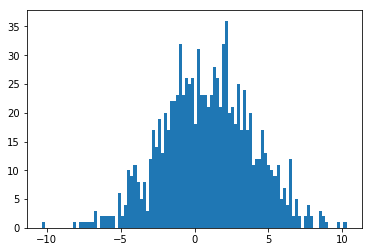

In [3]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
from matplotlib import pyplot as plt

# We will first draw some normally distributed observations
# to predict later on

MU = 0.87
SIGMA = 3.14
OBS = np.random.normal(loc=MU, scale=SIGMA, size=1000)

plt.hist(OBS, 100);

## 1. Model creation

Models in PyMC3 are centered around the `Model` class. It has references to all random variables (RVs) and computes the model `logp` and its gradients. Usually, you would instantiate it as part of a `with` context:

In [4]:
with pm.Model() as model:
    # Model definition
    pass
print(type(model))
model

<class 'pymc3.model.Model'>


We discuss RVs further below but let’s create a simple model to explore the `Model` class.

In [5]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.Gamma('sigma', alpha=1, beta=1)
    observed = pm.Normal('obs', mu=mu, sigma=sigma,
                         observed=OBS)

# We can view the basic RVs
print('Basic RVs', model.basic_RVs)

# We can view the free RVs that are used for MCMC
print('Free RVs', model.free_RVs)

# We can view the observed RVs
print('Observed RVs', model.observed_RVs)

# We can view the deterministic RVs (nodes in the graph that are determined by others)
print('Deterministics', model.deterministics)

# We can also compute the unnormalized log posterior probability
point = model.test_point
point['mu'] = 0
point['sigma'] = 1
model.logp(point)

Basic RVs [mu, sigma_log__, obs]
Free RVs [mu, sigma_log__]
Observed RVs [obs]
Deterministics [sigma]


array(-5938.83424916)

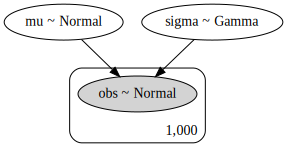

In [6]:
# We can view the probabilistic graphical model
pm.model_to_graphviz(model)

## 2. Probability Distributions

PyMC3 comes with several [built-in probability distributions](https://docs.pymc.io/api/distributions.html) that can be used to create models

In [7]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(m

In [8]:
help(pm.NormalMixture)

Help on class NormalMixture in module pymc3.distributions.mixture:

class NormalMixture(Mixture)
 |  Normal mixture log-likelihood
 |  
 |  .. math::
 |  
 |      f(x \mid w, \mu, \sigma^2) = \sum_{i = 1}^n w_i N(x \mid \mu_i, \sigma^2_i)
 |  
 |  ========  =======================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\sum_{i = 1}^n w_i \mu_i`
 |  Variance  :math:`\sum_{i = 1}^n w_i^2 \sigma^2_i`
 |  ========  =======================================
 |  
 |  Parameters
 |  ----------
 |  w : array of floats
 |      w >= 0 and w <= 1
 |      the mixture weights
 |  mu : array of floats
 |      the component means
 |  sigma : array of floats
 |      the component standard deviations
 |  tau : array of floats
 |      the component precisions
 |  comp_shape : shape of the Normal component
 |      notice that it should be different than the shape
 |      of the mixture distribution, with one axis being
 |      the number of components.
 |  
 |  Note: Yo

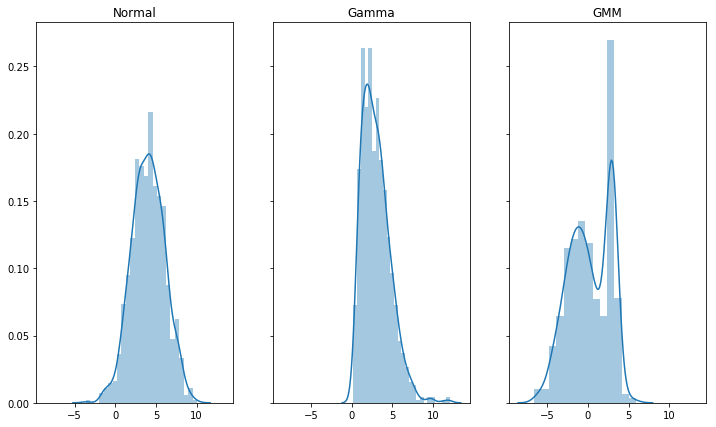

In [9]:
# One can create distribution objects that are detached from RVs
norm = pm.Normal.dist(mu=4, sigma=2)
gamm = pm.Gamma.dist(alpha=3, beta=1)
gmm = pm.NormalMixture.dist(mu=np.array([-1, 3]),
                            sigma=np.array([2, 0.3]),
                            w=np.array([0.7, 0.3]))

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 7))
ax = axs[0]
sns.distplot(norm.random(size=1000), ax=axs[0])
axs[0].set_title('Normal')
sns.distplot(gamm.random(size=1000), ax=axs[1])
axs[1].set_title('Gamma')
sns.distplot(gmm.random(size=1000), ax=axs[2])
axs[2].set_title('GMM')
ax = axs[0]

In [10]:
# The logp method returns a theano tensor, which is used to get
# the gradients
import theano
from theano import tensor as tt
x = tt.dscalar('something')
x.tag.test_value = 0
logp_x = norm.logp(x)
theano.printing.debugprint(logp_x)
print(type(logp_x))

Elemwise{switch,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | |TensorConstant{1} [id C]
 | |Elemwise{mul,no_inplace} [id D] ''   
 |   |TensorConstant{1} [id C]
 |   |Elemwise{gt,no_inplace} [id E] ''   
 |     |TensorConstant{2.0} [id F]
 |     |TensorConstant{0} [id G]
 |Elemwise{true_div,no_inplace} [id H] ''   
 | |Elemwise{add,no_inplace} [id I] ''   
 | | |Elemwise{mul,no_inplace} [id J] ''   
 | | | |Elemwise{neg,no_inplace} [id K] ''   
 | | | | |TensorConstant{0.25} [id L]
 | | | |Elemwise{pow,no_inplace} [id M] ''   
 | | |   |Elemwise{sub,no_inplace} [id N] ''   
 | | |   | |something [id O]
 | | |   | |TensorConstant{4.0} [id P]
 | | |   |TensorConstant{2} [id Q]
 | | |Elemwise{log,no_inplace} [id R] ''   
 | |   |Elemwise{true_div,no_inplace} [id S] ''   
 | |     |Elemwise{true_div,no_inplace} [id T] ''   
 | |     | |TensorConstant{0.25} [id L]
 | |     | |TensorConstant{3.141592653589793} [id U]
 | |     |TensorConstant{2.0} [id V]
 | |TensorConsta

In [11]:
# Each free random variable has its logp callable
print(mu.logp(point))
print(model['sigma_log__'].logp(point))

-0.9189385332046727
-1.0


In [12]:
# And its corresponding logp theano variable
theano.printing.debugprint(mu.logpt)

Sum{acc_dtype=float64} [id A] '__logp_mu'   
 |Elemwise{switch,no_inplace} [id B] ''   
   |Elemwise{mul,no_inplace} [id C] ''   
   | |TensorConstant{1} [id D]
   | |Elemwise{mul,no_inplace} [id E] ''   
   |   |TensorConstant{1} [id D]
   |   |Elemwise{gt,no_inplace} [id F] ''   
   |     |TensorConstant{1.0} [id G]
   |     |TensorConstant{0} [id H]
   |Elemwise{true_div,no_inplace} [id I] ''   
   | |Elemwise{add,no_inplace} [id J] ''   
   | | |Elemwise{mul,no_inplace} [id K] ''   
   | | | |Elemwise{neg,no_inplace} [id L] ''   
   | | | | |TensorConstant{1.0} [id G]
   | | | |Elemwise{pow,no_inplace} [id M] ''   
   | | |   |Elemwise{sub,no_inplace} [id N] ''   
   | | |   | |mu [id O]
   | | |   | |TensorConstant{0.0} [id P]
   | | |   |TensorConstant{2} [id Q]
   | | |Elemwise{log,no_inplace} [id R] ''   
   | |   |Elemwise{true_div,no_inplace} [id S] ''   
   | |     |Elemwise{true_div,no_inplace} [id T] ''   
   | |     | |TensorConstant{1.0} [id G]
   | |     | |TensorConsta

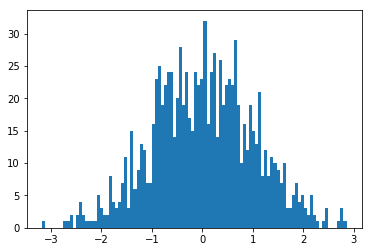

In [13]:
# Each random variable has its random method to draw samples from it conditional on its parents
plt.hist(mu.random(size=1000), 100);

{'sigma_log__': (1000,), 'mu': (1000,), 'obs': (1000, 1000), 'sigma': (1000,)}


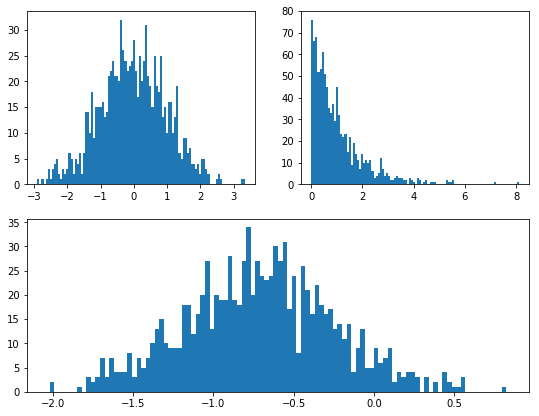

In [14]:
# Models can be used to generate forward samples (sample_prior_predictive)
with model:
    prior = pm.sample_prior_predictive(1000)
print({k: v.shape for k, v in prior.items()})

plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.hist(prior['mu'], 100)
plt.subplot(222)
plt.hist(prior['sigma'], 100)
plt.subplot(212)
plt.hist(prior['obs'][:, 0], 100);

## 3. Inference
Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

### 3.1 Sampling

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 2061.99draws/s]


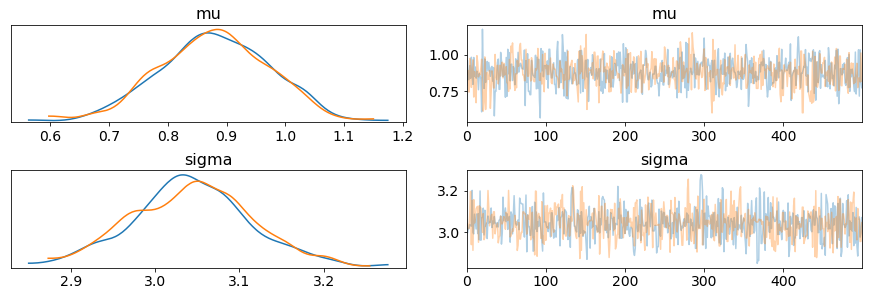

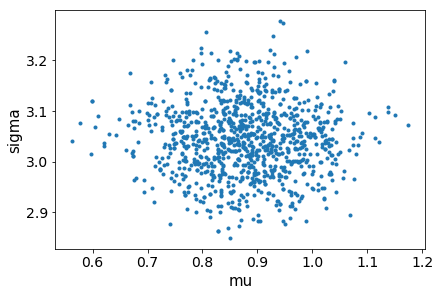

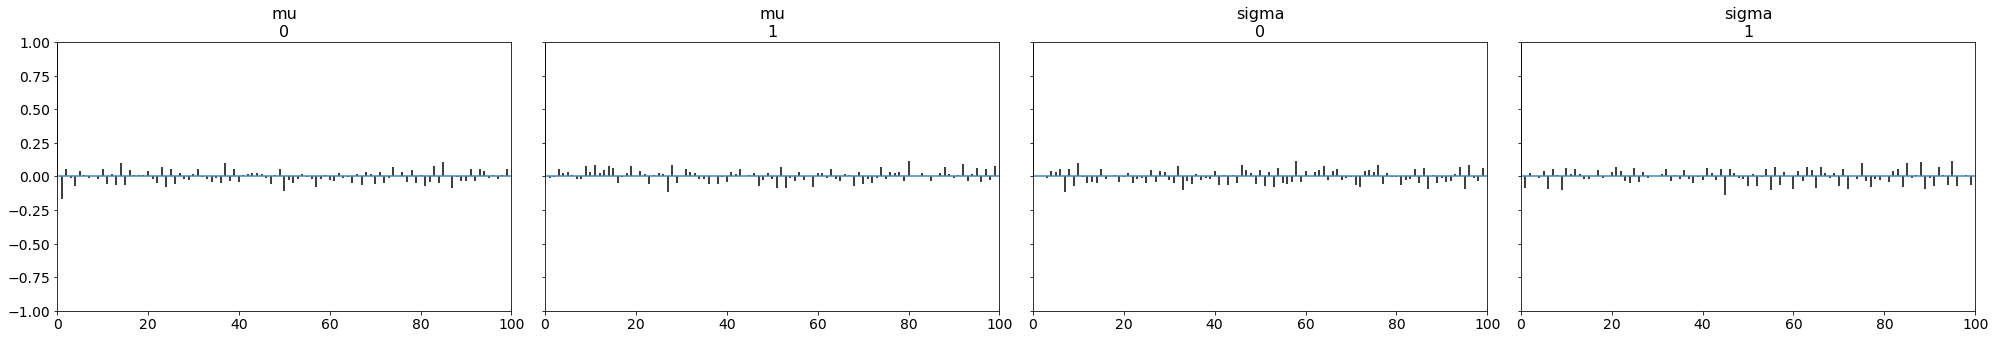

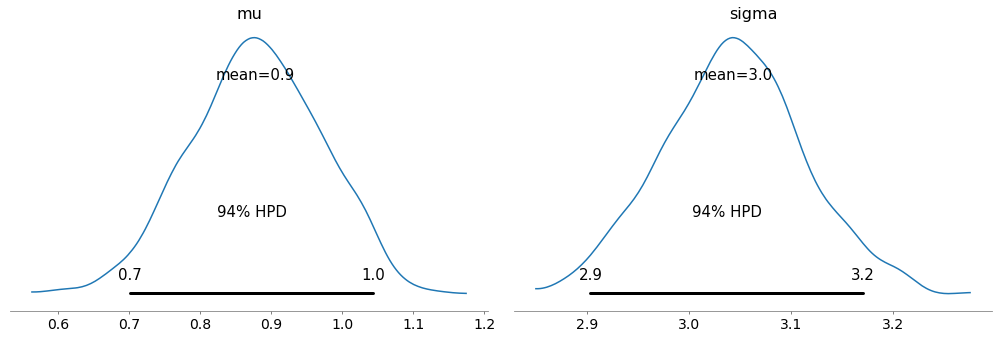

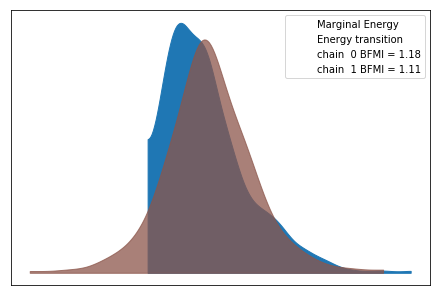

In [15]:
with model:
    trace = pm.sample()
    pm.traceplot(trace)
    pm.pairplot(trace)
    pm.plot_autocorr(trace)
    pm.plot_posterior(trace)
    pm.energyplot(trace)

### 3.2 Variational inference
PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc3.fit()`

In [16]:
with model:
    approx = pm.fit()
print(approx)

Average Loss = 2,569.4: 100%|██████████| 10000/10000 [00:03<00:00, 2839.12it/s]
Finished [100%]: Average Loss = 2,569.3


Approximation{MeanFieldGroup[2]}


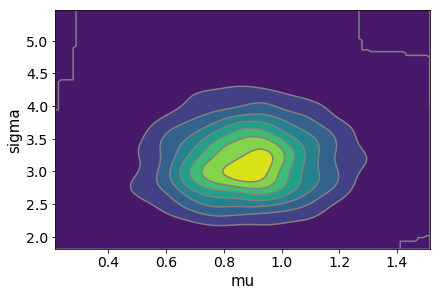

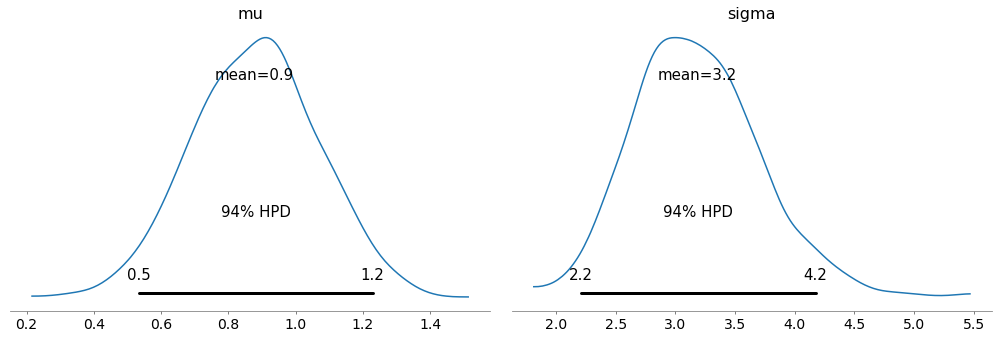

In [17]:
approx_samples = approx.sample(2000)
with model:
    pm.pairplot(approx_samples, kind='kde')
    pm.plot_posterior(approx_samples)

The variational submodule offers a lot of flexibility in which VI to use and follows an object oriented design. For example, full-rank ADVI estimates a full covariance matrix:

In [18]:
with model:
    approx1 = pm.fit(method='fullrank_advi')
    # Or object oriented method
    approx2 = pm.FullRankADVI().fit()
print(approx1)
print(approx2)

Average Loss = 2,539.1: 100%|██████████| 10000/10000 [00:05<00:00, 1707.85it/s]
Finished [100%]: Average Loss = 2,539.1
Average Loss = 2,539.1: 100%|██████████| 10000/10000 [00:05<00:00, 1797.50it/s]
Finished [100%]: Average Loss = 2,539.1


Approximation{FullRankGroup[2]}
Approximation{FullRankGroup[2]}


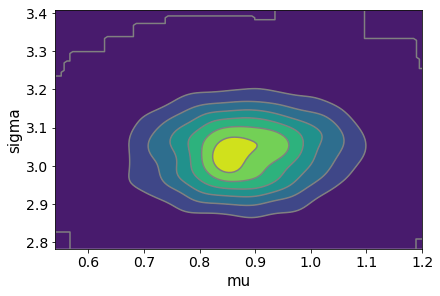

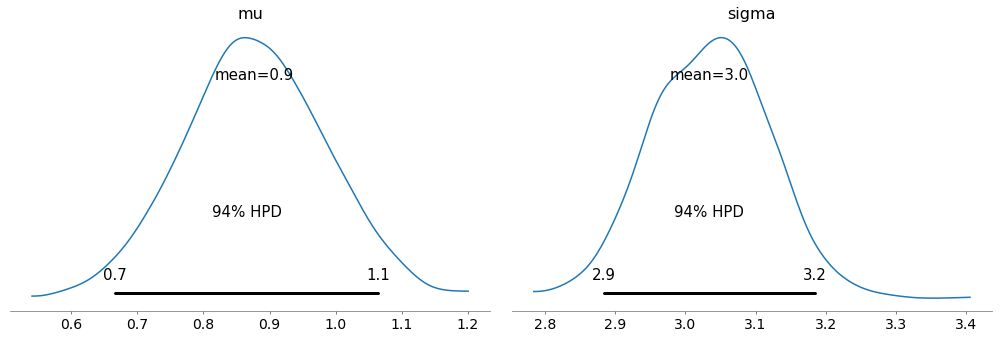

In [19]:
approx_samples = approx1.sample(2000)
with model:
    pm.pairplot(approx_samples, kind='kde')
    pm.plot_posterior(approx_samples)

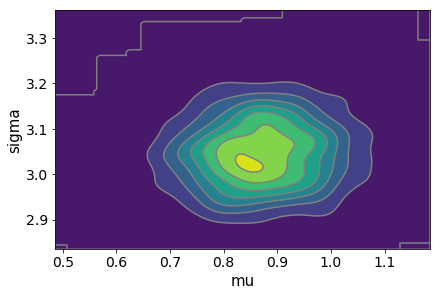

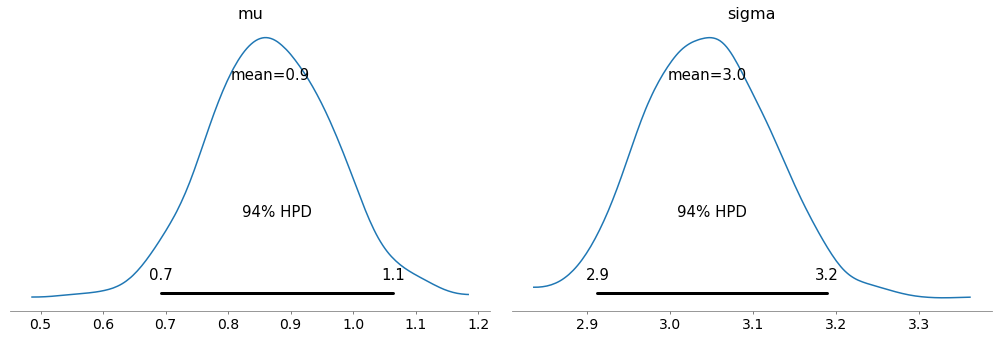

In [20]:
approx_samples = approx2.sample(2000)
with model:
    pm.pairplot(approx_samples, kind='kde')
    pm.plot_posterior(approx_samples)

## 4. Posterior predictive sampling

The `sample_posterior_predictive()` function performs prediction on hold-out data and posterior predictive checks.

In [21]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:00<00:00, 2703.65it/s]


In [22]:
ppc['obs'].shape

(1000, 1000)

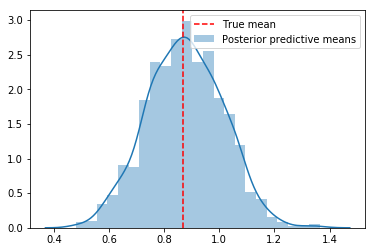

In [23]:
plt.figure()
ax = sns.distplot(ppc['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(MU, color='r', ls='--', label='True mean')
ax.legend();

## 5. Point estimate
We can also compute the MAP through optimization using the `fit_MAP` function

In [24]:
with model:
    MAP = pm.find_MAP()
MAP

/home/lpaz/repos/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,535.9, ||grad|| = 0.0038575: 100%|██████████| 13/13 [00:00<00:00, 1870.92it/s]  


{'mu': array(0.87503404),
 'sigma': array(3.03777941),
 'sigma_log__': array(1.11112679)}

---

##### Exercises
1. Build a model that corresponds to the following generative process
$$
\alpha \sim Dirichlet(1, 3, 0.1)\\
z \sim Categorical(\alpha)
$$
2. View the probabilistic model's graph
3. Draw samples from the prior distribution
4. Set observations to $z$ taken from the prior draw and infer the posterior distribution on $\alpha$.
5. Make predictions for $z$ given the inferred $\alpha$.

### To be continued with other features taken from the [docs](https://docs.pymc.io/nb_examples/index.html)...